In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
import gensim
from gensim import models
from pprint import pprint
from gensim.models import CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.manifold import TSNE

In [144]:
sns.color_palette('icefire')
sns.set_palette('icefire')


# Recommender # 2

## Data cleaning based on previous work
For the collaborative filter, I combined the business and reviews dataframe, subsetting restaurants in New Orleans, dropped irrelevant columns and filtered out users who have more than 50 reviews and businesses which  have more than 50 reviews.

In [3]:
path = '/Users/shafz/OneDrive/Documents/machine-learning-dse-i210-final-project-yelprestaurantrecommender/data/raw/'
business = pd.read_csv(path+'raw_business.csv')
restaurants = business[business.categories.fillna('-').str.lower().str.contains('restaurant')]

restaurants.columns = ['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'biz_stars', 'biz_review_count', 'is_open',
       'attributes', 'categories', 'hours']

restaurants = restaurants.drop(['address', 'state', 'postal_code',
       'latitude', 'longitude', 'is_open', 'attributes', 'hours'], axis = 1)

restaurants.shape

(52286, 6)

In [4]:
# removing irrelevant categories
lst = ['Automotive','Bed & Breakfast']  # categories we want to exclude 
rstr = '|'.join(lst)
idx_to_remove = restaurants[restaurants.categories.fillna('-').str.contains(rstr)].index
restaurants.drop(idx_to_remove, axis = 0, inplace=True)

restaurants.shape

(51934, 6)

In [5]:
reviews = pd.read_csv(path  + 'raw_reviews.csv')

In [6]:
reviews.drop('Unnamed: 0', axis =1, inplace = True)
reviews = reviews.drop(['useful', 'funny','cool','date'], axis = 1)

In [7]:
# merging business and reviews data together, filtering out the restaurants in New Orleans, and dropping duplicates
merged_df = pd.merge(reviews, restaurants, on='business_id')
nola = merged_df.loc[merged_df['city']=='New Orleans']
nola = nola.drop_duplicates(['user_id', 'business_id', 'stars'], keep='first')

In [8]:
## I'm going to focus my analysis on users that have at least 50 reviews and restaurants that have at least 50 reviews 
user_counts = nola['user_id'].value_counts().to_dict()
user_list = []

for key in user_counts.keys(): 
    if user_counts[key] >= 50: 
        user_list.append(key)

filtered_nola = nola[nola['user_id'].isin(user_list)]
print('Data shape after filtering by users: ', filtered_nola.shape)

biz_counts = filtered_nola['business_id'].value_counts().to_dict()
biz_list = []

for key in biz_counts.keys(): 
    if biz_counts[key] >= 25: 
        biz_list.append(key)

filtered_nola = filtered_nola[filtered_nola['business_id'].isin(biz_list)]
print('Data shape after also filtering by restaurants: ', filtered_nola.shape)
print('Unique users: ', len(filtered_nola['user_id'].unique()))
print('Unqiue businesses: ', len(filtered_nola['business_id'].unique()))

Data shape after filtering by users:  (30925, 10)
Data shape after also filtering by restaurants:  (19539, 10)
Unique users:  327
Unqiue businesses:  436


In [9]:
user_data = pd.read_csv(path + 'raw_users.csv')
user_stars = user_data[['user_id', 'average_stars']]

In [10]:
filtered_nola = pd.merge(filtered_nola, user_stars, on='user_id')
filtered_nola['stars'].value_counts()

4    7613
5    6173
3    3805
2    1432
1     516
Name: stars, dtype: int64

In [11]:
## create a dictionary which maps business id to restaurant name
biz_dict = {}
biz_avg_ratings = {}
user_avg_ratings = {}

for row in filtered_nola.itertuples():
    biz_dict[row.business_id] = row.name
    biz_avg_ratings[row.business_id] = row.biz_stars
    user_avg_ratings[row.user_id] = row.average_stars

## Data Preparation

I had previously tried to do a train test split using sklearn's train_test_split function but that was a HUGE mess so we are going to do something completely different now

In [12]:
def calcSparsity(df):
    number_of_empty = df.isnull().values.sum()
    total_number = df.size
    sparsity = number_of_empty/total_number
    print('Sparsity: {}'.format(round(sparsity,3)))

def makePivot(df):
    user_ratings = df[['user_id', 'business_id', 'stars']]
    user_ratings_pivot = user_ratings.pivot_table(index='user_id', columns='business_id', values='stars', aggfunc='mean')
    return user_ratings_pivot

In [13]:
nola_pivot = makePivot(filtered_nola)
calcSparsity(nola_pivot)
nola_pivot.head()

Sparsity: 0.87


business_id,-If0ps0QhOLCYVWQWs9RYg,-Tskf8WK17rb3ZfeFuRSWA,-VlBFlHwX-Pt6Xyzs9roGw,-fJPJP7iOd1ukDNqTSINIg,-psZLTe6IJTQUB-bZF7Zyg,06NHXjVHiGKNpZ2XeajVkA,0DdmKihJ90qKP5TAM3c2yQ,0KTwW1eC1YAjR-zDr8w4jA,0UJqTczta018RoktahC0jw,0ZeGH15LV98FuijA1XrWoA,...,yTJ2Ir6CMBzThLK5dmACvQ,yY3kq6_2m1FyY9MgaiHgoQ,ydmJoaK1PMlwLvMnbFXf1w,yf8a1DOlqoqlKHuLSKEfxg,yz0KWVamNhqiZGz7XTClzg,z0MXYel0okwMqLjgMkKD2A,zSqTndm5Alq9dW1PyzbdTA,zWfzgYe2nT9mHYm_vl1Ukw,zYyVEC0IF86xSHF3GFmvkg,zgpx6YqA7KeY9-3xbNEn3A
user_id,,,,,,,,,,,,,,,,,,,,,
-MRD72DXnVgjkM1AVFp7Nw,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
-SO_K8oLVH_9J23z2MtjGg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,5.0,NaN,5.0,NaN,NaN
-Tg5YTEMbnYw3fQN99xKCQ,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-V7frksbFjKQYVhrPnnlPw,4.0,4.0,5.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,3.0,3.0,4.0,NaN
-_Y8Mal7S750TsB6yMMDHA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
train = nola_pivot.iloc[:50, :100]
val = nola_pivot.iloc[110:140, 150:200]
test = nola_pivot.iloc[230:300, 300:400]

nola_copy = nola_pivot.copy()
nola_copy.iloc[:50, :100] = np.nan
nola_copy.iloc[110:140, 150:200] = np.nan
nola_copy.iloc[230:300, 300:400] = np.nan

calcSparsity(nola_copy)

Sparsity: 0.883


In [62]:
print('train shape: ', train.shape)
print('val shape: ', val.shape)
print('test shape: ', test.shape)

train shape:  (50, 100)
val shape:  (30, 50)
test shape:  (80, 100)


## Some Simple Baselines 

Just for comparisons sake, we are going to see what our root mean squared error (RMSE) and mean absolute error (MAE) come out to if we just predict the average business rating / average user rating every single time. Even though I can do this on the entire dataframe in one go since we are not training anything and theres no threat of information leakage in any way, I am still going to apply it to each split individually so we can compare easily later on

In [99]:
def predictAvgBiz(df, user = False):
    ## input = pivot table of users and businesses 
    pred_df = pd.DataFrame(columns=list(df.columns), index=df.index)

    if user: 
        for user in pred_df.index: 
           pred_df.loc[pred_df.index==user] = user_avg_ratings[user]
    else: 
        for col in pred_df.columns: 
           pred_df[col] = biz_avg_ratings[col]

    mask = ~np.isnan(df)
    gt_stars = df.values[mask]
    pred = pred_df.values[mask]

    return (mean_squared_error(gt_stars, pred, squared=False), mean_absolute_error(gt_stars, pred))

In [71]:
### Predicting average business rating as user rating 
## evaluating train set 
train_rmse, train_mae = predictAvgBiz(train, user = False)
print('Train rmse: ', round(train_rmse, 3))
print('Train mae: ', round(train_mae, 3))
print('-------------------------------------')
## evaluating validation set 
val_rmse, val_mae = predictAvgBiz(val, user = False)
print('Val rmse: ', round(val_rmse, 3))
print('Val mae: ', round(val_mae, 3))
print('-------------------------------------')
## evaluating test set 
test_rmse, test_mae = predictAvgBiz(test, user = False)
print('Test rmse: ', round(test_rmse, 3))
print('Test mae: ', round(test_mae, 3))

Train rmse:  0.918
Train mae:  0.698
-------------------------------------
Val rmse:  0.924
Val mae:  0.74
-------------------------------------
Test rmse:  0.985
Test mae:  0.774


In [72]:
### Predicting average user rating as user rating 
## evaluating train set 
train_rmse, train_mae = predictAvgBiz(train, user = True)
print('Train rmse: ', round(train_rmse, 3))
print('Train mae: ', round(train_mae, 3))
print('-------------------------------------')
## evaluating validation set 
val_rmse, val_mae = predictAvgBiz(val, user = True)
print('Val rmse: ', round(val_rmse, 3))
print('Val mae: ', round(val_mae, 3))
print('-------------------------------------')
## evaluating test set 
test_rmse, test_mae = predictAvgBiz(test, user = True)
print('Test rmse: ', round(test_rmse, 3))
print('Test mae: ', round(test_mae, 3))

Train rmse:  0.849
Train mae:  0.649
-------------------------------------
Val rmse:  0.847
Val mae:  0.693
-------------------------------------
Test rmse:  0.938
Test mae:  0.72


## Building the Filter
For the collaborative filer, I 

* Created a pivot table where the rows are the users and the columns are the different restaurants. The value in each cell is the user rating for that restaurant.
* Calculated the sparsity 
* Normalized the data and set all NaNs to 0.
* Filled in the missing values using singular value decomposition (SVD) 
* Found most similar users using cosine similarity 
* Did some brief analysis on the results of the cosine similarity 
* Built a collaborative filter by combining the normalization, SVD reconstruction, and cosine similarity calculation
    * The collaborative filter finds the top five most similar users to a given user, calculates the average rating of restaurants that the similar users have visited but the user of interest has not and then recommends the top 5 restaurants with the highest ratings.
* Evaluaed performance using MSE and MAE
* Determined the optimal value of k based on the MSE and MAE 

### Filling in Missing Values with SVD

In [72]:
def compute_filled_matrix(pivot_df, k_val):
    """
    Takes in the number of latent vectors and outputs 
    a reconstructed/filled pivot table 
    """
    # Normalize pivot table 
    avg_ratings = pivot_df.mean(axis=1)
    user_ratings_centered = pivot_df.sub(avg_ratings, axis=0)
    user_ratings_centered = user_ratings_centered.fillna(0)

    # Calculate SVD and use it to reconstruct the pivot table 
    U, sigma, Vt = svds(user_ratings_centered.to_numpy(), k = k_val, tol=0)
    sigma = np.diag(sigma)
    # print(U.shape)
    # print(Vt.shape)
    recalculated_ratings = np.dot(np.dot(U, sigma), Vt)
    recalculated_ratings = recalculated_ratings + avg_ratings.values.reshape(-1, 1)

    # Create a dataframe from the SVD recalculation 
    user_ratings_filled = pd.DataFrame(recalculated_ratings,
                                    index=pivot_df.index,
                                    columns=pivot_df.columns)

    return user_ratings_filled, U 

What type of performance do we get if we just use the reconstructed matrix for predictions?

In [70]:
nola_filled = compute_filled_matrix(nola_copy, 85)
nola_filled.head()

(327, 85)
(85, 436)


business_id,-If0ps0QhOLCYVWQWs9RYg,-Tskf8WK17rb3ZfeFuRSWA,-VlBFlHwX-Pt6Xyzs9roGw,-fJPJP7iOd1ukDNqTSINIg,-psZLTe6IJTQUB-bZF7Zyg,06NHXjVHiGKNpZ2XeajVkA,0DdmKihJ90qKP5TAM3c2yQ,0KTwW1eC1YAjR-zDr8w4jA,0UJqTczta018RoktahC0jw,0ZeGH15LV98FuijA1XrWoA,...,yTJ2Ir6CMBzThLK5dmACvQ,yY3kq6_2m1FyY9MgaiHgoQ,ydmJoaK1PMlwLvMnbFXf1w,yf8a1DOlqoqlKHuLSKEfxg,yz0KWVamNhqiZGz7XTClzg,z0MXYel0okwMqLjgMkKD2A,zSqTndm5Alq9dW1PyzbdTA,zWfzgYe2nT9mHYm_vl1Ukw,zYyVEC0IF86xSHF3GFmvkg,zgpx6YqA7KeY9-3xbNEn3A
user_id,,,,,,,,,,,,,,,,,,,,,
-MRD72DXnVgjkM1AVFp7Nw,4.288587,4.392630,4.162512,4.460925,4.468919,4.718762,4.426146,4.291790,4.751686,4.347350,...,4.478544,4.427244,4.318361,4.435611,4.453784,4.322794,4.310596,4.458841,4.663181,2.681210
-SO_K8oLVH_9J23z2MtjGg,4.116740,4.243840,4.260225,4.262626,4.315148,4.389642,4.239886,4.323938,4.123147,4.220708,...,4.297029,4.163622,4.146641,3.953925,3.900555,4.268007,4.096896,4.566306,4.195188,4.101599
-Tg5YTEMbnYw3fQN99xKCQ,3.767896,3.703646,3.612517,3.709250,3.777411,3.882855,3.598773,3.728560,3.682023,3.820787,...,3.794049,3.755723,3.783191,3.737777,3.726855,3.760155,3.558651,4.159780,3.574843,3.895961
-V7frksbFjKQYVhrPnnlPw,3.983353,3.937664,4.523312,3.714092,4.116047,4.118573,3.823823,4.168109,4.136671,4.039252,...,4.036839,3.887558,4.242337,3.807491,4.282793,3.765423,3.462858,3.106863,4.218349,3.964477
-_Y8Mal7S750TsB6yMMDHA,4.008548,3.816012,3.680216,3.879074,3.951134,3.935686,3.958683,3.687579,3.772666,3.858461,...,3.737603,3.744715,3.961055,3.821617,3.839211,3.805730,3.728714,3.864874,3.975997,3.911456


In [17]:
def eval(df, filled_df = nola_filled, split='train'):

    mask = ~np.isnan(df)
    gt = df.values[mask]

    if split=='train':
        preds = filled_df.iloc[:50, :100].values[mask]
    elif split =='val':
        preds = filled_df.iloc[110:140, 150:200].values[mask]
    else:
        preds = filled_df.iloc[230:300, 300:400].values[mask]
    
    return (mean_squared_error(gt, preds, squared=False), mean_absolute_error(gt, preds))

In [18]:
### train 
train_rmse, train_mae = eval(train)
print('-------------- Train -------------------')
print('RMSE: ', round(train_rmse,3))
print('MAE: ', round(train_mae,3))

### val
val_rmse, val_mae = eval(val, split='val')
print('-------------- Val -------------------')
print('RMSE: ', round(val_rmse,3))
print('MAE: ', round(val_mae, 3))

-------------- Train -------------------
RMSE:  0.864
MAE:  0.657
-------------- Val -------------------
RMSE:  0.843
MAE:  0.687


We beat the average business baseline!!  In terms of the avg user baseline, our RMSE and MAE is approximately the same. Lets optimize for value of k.

Text(0.5, 0, 'K value')

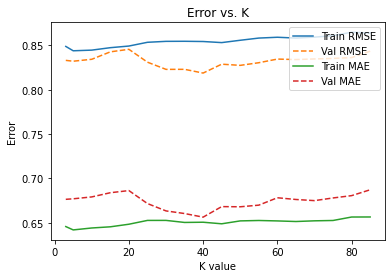

In [23]:
k_array = [3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]

train_rmse_list, train_mae_list = [], []
val_rmse_list, val_mae_list = [], []

for k in k_array:
    
    filled = compute_filled_matrix(nola_copy, k)
    train_rmse, train_mae = eval(train, filled_df = filled)
    val_rmse, val_mae = eval(val, filled_df = filled, split='val')

    train_rmse_list.append(train_rmse)
    train_mae_list.append(train_mae)
    val_rmse_list.append(val_rmse)
    val_mae_list.append(val_mae)

plt.plot(k_array, train_rmse_list, label = 'Train RMSE')
plt.plot(k_array, val_rmse_list, '--', label = 'Val RMSE')
plt.plot(k_array, train_mae_list, label = 'Train MAE')
plt.plot(k_array, val_mae_list, '--', label = 'Val MAE')
plt.legend(loc = 1)
plt.title('Error vs. K')
plt.ylabel('Error')
plt.xlabel('K value')

In [24]:
print('Minimum RMSE on val: {}, index: {} '.format(min(val_rmse_list), val_rmse_list.index(min(val_rmse_list))))
print('Minimum MAE on val: {}, index: {} '.format(min(val_mae_list), val_mae_list.index(min(val_mae_list))))
print('K at minimum index: ', k_array[val_rmse_list.index(min(val_rmse_list))])

Minimum RMSE on val: 0.8186895529566119, index: 8 
Minimum MAE on val: 0.6564737891115646, index: 8 
K at minimum index:  40


We beat both baselines!!! Lets evaluate on the test set

In [74]:
### test 
filled_nola = compute_filled_matrix(nola_copy, 45)
test_rmse, test_mae = eval(test, filled_df = filled_nola, split='test')
print('-------------- Test -------------------')
print('RMSE: ', test_rmse)
print('MAE: ', test_mae)

-------------- Test -------------------
RMSE:  0.9479354556552101
MAE:  0.7202274761180895


We beat the average business rating baseline but get basically the same results as the average user rating baseline which is not good. What happens if we try to include ratings from similar users

### Finding Similarities

In [19]:
def find_sim_users(filled_df, user, cats = False):
    """
    Takes in the SVD array and the user of interest for whom we want
    to make recommendations 
    """
    # Normalize the reconstructed matrix 
    avg_ratings = filled_df.mean(axis=1)
    user_ratings_centered = filled_df.sub(avg_ratings, axis=0)
    if cats: 
        user_ratings_centered = user_ratings_centered.fillna(0)
    similarities = cosine_similarity(user_ratings_centered)
    cosine_similarity_df = pd.DataFrame(similarities, index=user_ratings_centered.index, columns=user_ratings_centered.index)
    #cosine_similarity_df.head()

    # find the most similar users and return a sorted series 
    cosine_similarity_series = cosine_similarity_df.loc[user]
    ordered_similarities = cosine_similarity_series.sort_values(ascending=False)
    #print(ordered_similarities)

    return ordered_similarities

In [20]:
user_of_interest = 'NWUQCWiY0w97l2mcWq9GAQ'
ordered = find_sim_users(filled_nola, user_of_interest)
ordered

NameError: name 'filled_nola' is not defined

In [28]:
top5 = ordered[:4].index.to_list()
weights = ordered[:4].values

sim_users = filled_nola[val.columns]
sim_users = sim_users.loc[sim_users.index.isin(top5)]
avg_ratings = pd.DataFrame(sim_users.mean(axis=0)).T
user_of_interest = val.loc[val.index=='NWUQCWiY0w97l2mcWq9GAQ']

mask = user_of_interest.notna()
preds = avg_ratings.values[mask]
gt = user_of_interest.values[mask]

print(mean_squared_error(gt, preds, squared=False))
print(mean_squared_error(gt, preds))

0.8484869468300535
0.719930098940986


In [21]:
def evaluateRecommendation(filled_df, split_df, user= None, cats = False, cat_df = None, avg_user = 5): 

    if cats: 
        ordered = find_sim_users(cat_df, user, cats)
    else: 
        ordered = find_sim_users(filled_df, user)
    top5 = ordered[:avg_user].index.to_list()

    sim_users = filled_df[split_df.columns]
    sim_users = sim_users.loc[sim_users.index.isin(top5)]
    avg_ratings = pd.DataFrame(sim_users.mean(axis=0)).T
    user_of_interest = split_df.loc[split_df.index==user]

    mask = user_of_interest.notna()
    preds = avg_ratings.values[mask]
    gt = user_of_interest.values[mask]

    rmse = mean_squared_error(gt, preds, squared=False)
    mae = mean_absolute_error(gt, preds)

    return rmse, mae

In [30]:
## entire pipeline
mse = []
mae = []
users_of_interest = val.index.values
for user in users_of_interest:
    user_rmse, user_mae = evaluateRecommendation(filled_nola, val, user)
    mse.append(user_rmse)
    mae.append(user_mae)

print('Average mean squared error: ', np.round(np.mean(mse),5))
print('Average mean absolute error: ', np.round(np.mean(mae),5))

Average mean squared error:  0.81795
Average mean absolute error:  0.70695


Text(0.5, 0, 'K value')

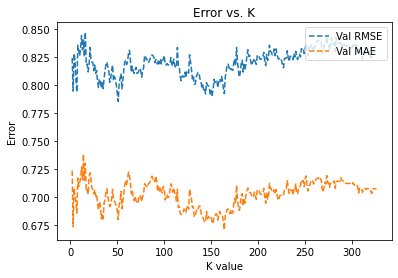

In [31]:
k_array = np.arange(2, 327)
train_rmse_list, train_mae_list = [], []
val_rmse_list, val_mae_list = [], []

for k in k_array:
    
    filled = compute_filled_matrix(nola_copy, k)
    rmse = []
    mae = []
    users_of_interest = val.index.values
    for user in users_of_interest:
        user_rmse, user_mae = evaluateRecommendation(filled, val, user)
        rmse.append(user_rmse)
        mae.append(user_mae)

    val_rmse_list.append(np.mean(rmse))
    val_mae_list.append(np.mean(mae))

#plt.plot(k_array, train_rmse_list, label = 'Train RMSE')
plt.plot(k_array, val_rmse_list, '--', label = 'Val RMSE')
#plt.plot(k_array, train_mae_list, label = 'Train MAE')
plt.plot(k_array, val_mae_list, '--', label = 'Val MAE')
plt.legend(loc = 1)
plt.title('Error vs. K')
plt.ylabel('Error')
plt.xlabel('K value')

In [32]:
print('Minimum RMSE on val: {}, index: {} '.format(min(val_rmse_list), val_rmse_list.index(min(val_rmse_list))))
print('Minimum MAE on val: {}, index: {} '.format(min(val_mae_list), val_mae_list.index(min(val_mae_list))))
print('K at minimum index: ', k_array[val_rmse_list.index(min(val_rmse_list))])

Minimum RMSE on val: 0.7854853722911358, index: 49 
Minimum MAE on val: 0.6707116525144872, index: 162 
K at minimum index:  51


We beat the average user baseline!!!!!!!!!
Lets see if changing the number of users we are averaging helps improve performance furthur 

Text(0.5, 0, 'K value')

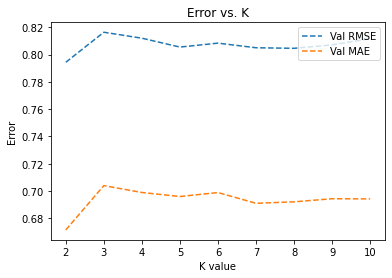

In [33]:
number_users = np.arange(2,11)
train_rmse_list, train_mae_list = [], []
val_rmse_list, val_mae_list = [], []

for numb in number_users:
    
    filled = compute_filled_matrix(nola_copy, 31)
    rmse = []
    mae = []
    users_of_interest = val.index.values
    for user in users_of_interest:
        user_rmse, user_mae = evaluateRecommendation(filled, val, user, avg_user = numb)
        rmse.append(user_rmse)
        mae.append(user_mae)

    val_rmse_list.append(np.mean(rmse))
    val_mae_list.append(np.mean(mae))

#plt.plot(k_array, train_rmse_list, label = 'Train RMSE')
plt.plot(number_users, val_rmse_list, '--', label = 'Val RMSE')
#plt.plot(k_array, train_mae_list, label = 'Train MAE')
plt.plot(number_users, val_mae_list, '--', label = 'Val MAE')
plt.legend(loc = 1)
plt.title('Error vs. K')
plt.ylabel('Error')
plt.xlabel('K value')

In [34]:
print('Minimum RMSE on val: {}, index: {} '.format(min(val_rmse_list), val_rmse_list.index(min(val_rmse_list))))
print('Minimum MAE on val: {}, index: {} '.format(min(val_mae_list), val_mae_list.index(min(val_mae_list))))
print('K at minimum index: ', number_users[val_rmse_list.index(min(val_rmse_list))])

Minimum RMSE on val: 0.7943327974667898, index: 0 
Minimum MAE on val: 0.6715527663667894, index: 0 
K at minimum index:  2


Im not sure if this is because we found k = 31 gives the lowest error earlier with number_users = 5 or if this is actually the case. Do I want to try doing every possible combination or some subset of?

## Lets try grouping the categories together 

In [17]:
def combineCols(names, col_list, df): 
    for name, cols in zip(names, col_list):
        # create a new column with the maximum value between the selected columns using a lambda function
        new_col = df[cols].apply(lambda row: max(row), axis=1)

        # drop the selected column
        df = df.drop(cols, axis=1)
        # add new column
        df[name] = new_col
    
    return df

In [18]:
dummies = filtered_nola['categories'].str.get_dummies(sep=',')
dummies.head()

,Active Life,American (New),American (Traditional),Arcades,Art Galleries,Arts & Entertainment,Asian Fusion,Auction Houses,Bagels,Bakeries,...,Sushi Bars,Tacos,Tapas/Small Plates,Tex-Mex,Thai,Vegan,Vegetarian,Venues & Event Spaces,Vietnamese,Wine Bars
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
## merging columns that have the same title but strings formatted differently 
## e.g. 'Active Life' vs ' Active Life' 

dummy_counts = dummies.sum().to_dict()
for key in dummy_counts.keys():

    key = key.strip()
    cols = dummies.filter(like=key).columns.tolist()
    #print(cols)

    if len(cols) > 1: 
        # create a new column with the maximum value between the selected columns using a lambda function
        new_col = dummies[cols].apply(lambda row: max(row), axis=1)
        #print(examp_df)
        # drop the selected columns
        dummies = dummies.drop(cols, axis=1)

        # add new column
        dummies[key] = new_col

columns = [col.strip() for col in dummies.columns]
dummies.columns = columns


In [20]:
random_categories = ['Arcades',
 'Art Galleries',
 'Bowling',
 'Community Service/Non-Profit',
 'Convenience Stores',
 'Country Clubs',
 'Fitness & Instruction',
 'Fruits & Veggies',
 'Gyms',
 'Karaoke',
 'Local Services',
 'Mass Media',
 'Music Venues',
 'Musicians',
 'Party & Event Planning',
 'Photographers',
 'Tobacco Shops',
 'Tours',
 'Personal Chefs',
 'Active Life',
 'Arts & Entertainment',
 'Caterers',
 'Event Planning & Services',
 'Food',
 'Grocery',
 'Hotels',
 'Jazz & Blues',
 'Local Flavor',
 'Restaurants',
 'Shopping',
 'Venues & Event Spaces']

dummies_filtered = dummies.drop(random_categories, axis = 1) # left with 179 columns 
to_drop = [ 'Argentine', 'Laotian','Pasta Shops','Kebab','Pakistani','Colombian','Halal','Falafel', 'Chicken Shop']
dummies_filtered = dummies_filtered.drop(to_drop, axis = 1)


In [21]:
categories_to_combine = [['Distilleries', 'Wine & Spirits', 'Wine Tasting Room', 'Bars', 'Beer', 'Breweries', 'Wineries', 'Nightlife', 'Lounges', 'Pubs'],
                            ['Auction Houses', 'Farmers Market'], ['Coffee & Tea', 'Coffee Roasteries', 'Cafes'], ['Waffles', 'Bagels', 'Breakfast & Brunch'],
                            ['Ice Cream & Frozen Yogurt', 'Gelato'],
                            ['Peruvian', 'Caribbean', 'Cuban',"Brazilian", 'Mexican', 'Tacos', 'Tapas/Small Plates', 'Latin American'], 
                            ['Meat Shops', 'Butcher'], ['Poke','Hawaiian'], 
                            ['Greek', 'Mediterranean', 'Middle Eastern'],
                            ["Korean", "Taiwanese", "Teppanyaki", "Noodles", "Ramen", "Chinese", "Dim Sum", "Japanese", "Asian Fusion"],
                            ['Vegan', 'Vegetarian'], ['Filipino', "Vietnamese", "Thai"],
                            ["German", 'Brasseries', "French", "Italian", "Irish", "Spanish", 'Modern European'],
                            ["Burgers", "Hot Dogs", 'Fish & Chips',"Pizza", 'Chicken Wings'],
                            ['Chocolatiers & Shops', 'Donuts', 'Desserts', 'Bakeries','Macarons', 'Patisserie/Cake Shop', 'Bakeries', 'Cupcakes', 'Creperies'],
                            ['American (New)', 'American (Traditional)', 'Barbeque', 'Cheesesteaks', 'Southern', 'Steakhouses']]

titles = ['Alcohol','Markets','Coffee_and_Tea', 'Breakfast', 
          'Frozen_Desserts', 'Latin American', 'Butcher', 'Hawaiian/Poke', 'Mediterranean',
          'East Asian', 'Vegan/Vegetarian', 'Southeast Asian', 'European', 'Fast Food', 'Desserts', 'American']

dummies_filtered = combineCols(titles, categories_to_combine, dummies_filtered)


In [22]:
dummies_filtered.corr().unstack().sort_values(ascending=False).drop_duplicates()[1:50]

Delis             Cheese Shops        0.382088
Southeast Asian   Bubble Tea          0.380631
Kosher            Mediterranean       0.353763
Cajun/Creole      Seafood             0.329464
Frozen_Desserts   Coffee_and_Tea      0.307275
Delis             Sandwiches          0.292775
Gastropubs        Bubble Tea          0.290678
Coffee_and_Tea    Desserts            0.286429
                  Breakfast           0.271451
Frozen_Desserts   Desserts            0.265229
Gluten-Free       Vegan/Vegetarian    0.250027
Southeast Asian   East Asian          0.245747
Soup              Salad               0.234683
Latin American    Tex-Mex             0.231026
Alcohol           American            0.226356
Sandwiches        Cheese Shops        0.217998
Hawaiian/Poke     Gluten-Free         0.207501
Kosher            Desserts            0.198766
Salad             Sandwiches          0.190894
Alcohol           Gastropubs          0.189844
Breakfast         Diners              0.177684
Cajun/Creole 

In [25]:
nola_final = pd.concat([filtered_nola, dummies_filtered], axis = 1)
nola_final = nola_final.drop(['categories'], axis = 1)
user_categories = nola_final.drop(['text', 'name', 'city',
       'biz_stars', 'biz_review_count', 'average_stars'], axis = 1)
user_categories.head()

,review_id,user_id,business_id,stars,Bubble Tea,Buffets,Cheese Shops,Ethiopian,Indian,Kosher,...,Butcher,Hawaiian/Poke,Mediterranean,East Asian,Vegan/Vegetarian,Southeast Asian,European,Fast Food,Desserts,American
0,lDoxqlDKb4H7zpI_zJ01aA,Ye-9S8f2dt41UBfy4lXffA,W4ZEKkva9HpAdZG88juwyQ,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,uNnqb1qJxUDS4qrM_mZxtA,Ye-9S8f2dt41UBfy4lXffA,PzhPMkaNYiKDTHoTG0r8rw,5,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,cA-WwCC7OFF6CreyTC_l2w,Ye-9S8f2dt41UBfy4lXffA,GBTPC53ZrG1ZBY3DT8Mbcw,5,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,lJpQrjnwqe9U3epf09FjcQ,Ye-9S8f2dt41UBfy4lXffA,GBTPC53ZrG1ZBY3DT8Mbcw,2,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,F1Q-Jh0r42iJ5OFy5QKMBA,Ye-9S8f2dt41UBfy4lXffA,OINbC0rpDVJ5bfxt3LO9fw,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
cols = ['Bubble Tea', 'Buffets',
       'Cheese Shops', 'Ethiopian', 'Indian', 'Kosher', 'Street Vendors',
       'Wraps', 'Festivals', 'Cajun/Creole', 'Delis', 'Diners', 'Gastropubs',
       'Gluten-Free', 'Salad', 'Sandwiches', 'Seafood', 'Soup', 'Tex-Mex',
       'Alcohol', 'Markets', 'Coffee_and_Tea', 'Breakfast', 'Frozen_Desserts',
       'Latin American', 'Butcher', 'Hawaiian/Poke', 'Mediterranean',
       'East Asian', 'Vegan/Vegetarian', 'Southeast Asian', 'European',
       'Fast Food', 'Desserts', 'American']

user_cats_mapped = user_categories.copy() 

for col in cols: 
    user_cats_mapped[col] = np.where(user_categories[col] == 1, user_categories['stars'], np.nan)

In [174]:
user_cats_mapped.head()

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,date,Bubble Tea,...,Butcher,Hawaiian/Poke,Mediterranean,East Asian,Vegan/Vegetarian,Southeast Asian,European,Fast Food,Desserts,American
0,18463,lDoxqlDKb4H7zpI_zJ01aA,Ye-9S8f2dt41UBfy4lXffA,W4ZEKkva9HpAdZG88juwyQ,2,3,0,0,2010-11-23 01:48:27,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,709449,uNnqb1qJxUDS4qrM_mZxtA,Ye-9S8f2dt41UBfy4lXffA,PzhPMkaNYiKDTHoTG0r8rw,5,1,0,0,2020-02-03 22:28:20,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
2,456571,cA-WwCC7OFF6CreyTC_l2w,Ye-9S8f2dt41UBfy4lXffA,GBTPC53ZrG1ZBY3DT8Mbcw,5,1,1,1,2014-09-14 12:27:34,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0
3,657377,lJpQrjnwqe9U3epf09FjcQ,Ye-9S8f2dt41UBfy4lXffA,GBTPC53ZrG1ZBY3DT8Mbcw,2,2,2,1,2021-07-25 19:41:43,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0
4,204444,F1Q-Jh0r42iJ5OFy5QKMBA,Ye-9S8f2dt41UBfy4lXffA,OINbC0rpDVJ5bfxt3LO9fw,5,2,3,1,2011-02-08 04:03:04,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Finding Similarities based on Categories

In [27]:
cats_mapped = user_cats_mapped.drop(['review_id', 'business_id', 'stars'], axis = 1)
cats_mapped = cats_mapped.groupby('user_id').mean()
#cats_mapped = cats_mapped.fillna(0)
cats_mapped

,Bubble Tea,Buffets,Cheese Shops,Ethiopian,Indian,Kosher,Street Vendors,Wraps,Festivals,Cajun/Creole,...,Butcher,Hawaiian/Poke,Mediterranean,East Asian,Vegan/Vegetarian,Southeast Asian,European,Fast Food,Desserts,American
user_id,,,,,,,,,,,,,,,,,,,,,
-MRD72DXnVgjkM1AVFp7Nw,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,...,NaN,NaN,4.500000,3.333333,4.750000,4.666667,5.000000,4.000000,4.000000,4.500000
-SO_K8oLVH_9J23z2MtjGg,5.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,3.428571,...,NaN,5.0,5.000000,4.285714,4.500000,4.666667,4.000000,4.125000,4.000000,4.315789
-Tg5YTEMbnYw3fQN99xKCQ,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.545455,...,NaN,NaN,NaN,5.000000,5.000000,NaN,4.500000,5.000000,NaN,3.615385
-V7frksbFjKQYVhrPnnlPw,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,5.0,4.347826,...,4.0,NaN,4.600000,3.500000,4.111111,4.000000,4.692308,4.217391,4.000000,4.120000
-_Y8Mal7S750TsB6yMMDHA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.384615,...,NaN,NaN,NaN,3.600000,5.000000,4.750000,4.000000,4.200000,3.000000,3.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yhwFVf8RwRfnuCK1vShjsg,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.500000,...,NaN,4.0,4.666667,4.000000,4.333333,4.333333,4.000000,4.000000,4.250000,3.888889
yon21mgAit4FGUZVWs_yfw,NaN,NaN,4.0,3.0,2.0,4.0,NaN,NaN,NaN,3.500000,...,NaN,NaN,3.333333,2.666667,3.500000,3.500000,3.538462,3.470588,3.846154,3.366667
zEemSTjoTpIKr_ZToYWQXQ,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,4.333333,...,5.0,NaN,5.000000,4.000000,5.000000,4.000000,4.250000,3.250000,4.500000,4.000000


In [31]:
## entire 
val_pivot = makePivot(val)
mse = []
mae = []
users_of_interest = val_pivot.index.values
for user in users_of_interest:
    user_rmse, user_mae = evaluateRecommendation(filled_nola, val_pivot, user, cats = True, cat_df=cats_mapped)
    mse.append(user_rmse)
    mae.append(user_mae)

print('Average mean squared error: ', np.round(np.mean(mse),5))
print('Average mean absolute error: ', np.round(np.mean(mae),5))

NameError: name 'val' is not defined

Text(0.5, 0, 'K value')

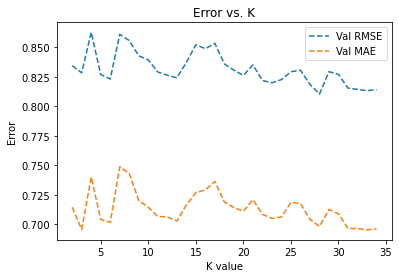

In [47]:
k_array = np.arange(2,35)

train_rmse_list, train_mae_list = [], []
val_rmse_list, val_mae_list = [], []
filled = compute_filled_matrix(nola_copy, 31)

for k in k_array:
        

    cats_filled = compute_filled_matrix(cats_mapped, k)
    rmse = []
    mae = []
    users_of_interest = val.index.values
    for user in users_of_interest:
        user_rmse, user_mae = evaluateRecommendation(filled, val, user, cats = True, cat_df=cats_filled)
        rmse.append(user_rmse)
        mae.append(user_mae)

    val_rmse_list.append(np.mean(rmse))
    val_mae_list.append(np.mean(mae))

#plt.plot(k_array, train_rmse_list, label = 'Train RMSE')
plt.plot(k_array, val_rmse_list, '--', label = 'Val RMSE')
#plt.plot(k_array, train_mae_list, label = 'Train MAE')
plt.plot(k_array, val_mae_list, '--', label = 'Val MAE')
plt.legend(loc = 1)
plt.title('Error vs. K')
plt.ylabel('Error')
plt.xlabel('K value')

In [48]:
print('Minimum RMSE on val: {}, index: {} '.format(min(val_rmse_list), val_rmse_list.index(min(val_rmse_list))))
print('Minimum MAE on val: {}, index: {} '.format(min(val_mae_list), val_mae_list.index(min(val_mae_list))))
print('K at minimum index: ', k_array[val_rmse_list.index(min(val_rmse_list))])


Minimum RMSE on val: 0.8103859000640853, index: 26 
Minimum MAE on val: 0.6952897663771483, index: 31 
K at minimum index:  28


## Lets try Jaccard

In [49]:
cols = ['Bubble Tea', 'Buffets',
       'Cheese Shops', 'Ethiopian', 'Indian', 'Kosher', 'Street Vendors',
       'Wraps', 'Festivals', 'Cajun/Creole', 'Delis', 'Diners', 'Gastropubs',
       'Gluten-Free', 'Salad', 'Sandwiches', 'Seafood', 'Soup', 'Tex-Mex',
       'Alcohol', 'Markets', 'Coffee_and_Tea', 'Breakfast', 'Frozen_Desserts',
       'Latin American', 'Butcher', 'Hawaiian/Poke', 'Mediterranean',
       'East Asian', 'Vegan/Vegetarian', 'Southeast Asian', 'European',
       'Fast Food', 'Desserts', 'American']

user_cats_binary = cats_mapped.copy() 

for col in cols: 
    user_cats_binary[col] = np.where(user_cats_binary[col] > 0, True, False)

In [16]:
def find_jaccard_users(binary, user):
    """
    Takes in the SVD array and the user of interest for whom we want
    to make recommendations 
    """
    similarities_jaccard = 1 - pairwise_distances(binary.to_numpy(), metric='jaccard')
    jaccard_similarity_df = pd.DataFrame(similarities_jaccard, index=binary.index, columns=binary.index)
    jaccard_similarity_series = jaccard_similarity_df.loc[user]
    ordered_similarities = jaccard_similarity_series.sort_values(ascending=False)

    return ordered_similarities

In [51]:
def evaluateJRecommendation(filled_df, jaccard, split_df, user= None): 

    ordered = find_jaccard_users(jaccard, user)
    top5 = ordered[:2].index.to_list()

    sim_users = filled_df[split_df.columns]
    sim_users = sim_users.loc[sim_users.index.isin(top5)]
    avg_ratings = pd.DataFrame(sim_users.mean(axis=0)).T
    user_of_interest = split_df.loc[split_df.index==user]

    mask = user_of_interest.notna()
    preds = avg_ratings.values[mask]
    gt = user_of_interest.values[mask]

    rmse = mean_squared_error(gt, preds, squared=False)
    mae = mean_absolute_error(gt, preds)

    return rmse, mae

In [52]:
filled = compute_filled_matrix(nola_copy, 31)
mse = []
mae = []
users_of_interest = val.index.values
for user in users_of_interest:
    user_rmse, user_mae = evaluateJRecommendation(filled, user_cats_binary, val, user)
    mse.append(user_rmse)
    mae.append(user_mae)
print('Average mean squared error: ', np.round(np.mean(mse),5))
print('Average mean absolute error: ', np.round(np.mean(mae),5))

Average mean squared error:  0.8173
Average mean absolute error:  0.69738


Using Jaccard Similarity instead did not help. Lets try both the jaccard similarity and the cosine similarity together because why not

In [155]:
def evaluateJCRecommendation(filled_df, jaccard, split_df, user): 

    ordered_cosine = find_sim_users(filled_df, user)
    ordered_jaccard = find_jaccard_users(jaccard, user)
    top2 = ordered_jaccard[1:3].index.to_list()
    top5 = ordered_cosine[:5].index.to_list()
    top = top2 + top5 

    sim_users = filled_df[split_df.columns]
    sim_users = sim_users.loc[sim_users.index.isin(top)]
    avg_ratings = pd.DataFrame(sim_users.mean(axis=0)).T
    user_of_interest = split_df.loc[split_df.index==user]

    mask = user_of_interest.notna()
    preds = avg_ratings.values[mask]
    gt = user_of_interest.values[mask]

    rmse = mean_squared_error(gt, preds, squared=False)
    mae = mean_absolute_error(gt, preds)

    return rmse, mae

In [54]:
filled = compute_filled_matrix(nola_copy, 31)
mse = []
mae = []
users_of_interest = val.index.values
for user in users_of_interest:
    user_rmse, user_mae = evaluateJCRecommendation(filled, user_cats_binary, val, user)
    mse.append(user_rmse)
    mae.append(user_mae)
print('Average mean squared error: ', np.round(np.mean(mse),5))
print('Average mean absolute error: ', np.round(np.mean(mae),5))

Average mean squared error:  0.8198
Average mean absolute error:  0.6935


## Test Set

In [75]:
filled = compute_filled_matrix(nola_copy, 31)
rmse = []
mae = []
users_of_interest = test.index.values
for user_id in users_of_interest:
    user_rmse, user_mae = evaluateJCRecommendation(filled, user_cats_binary, test, user_id)
    rmse.append(user_rmse)
    mae.append(user_mae)

print('Average mean squared error: ', np.round(np.mean(rmse),5))
print('Average mean absolute error: ', np.round(np.mean(mae),5))

Average mean squared error:  0.97025
Average mean absolute error:  0.79528


In [77]:
filled = compute_filled_matrix(nola_copy, 31)
rmse = []
mae = []
users_of_interest = test.index.values
for user_id in users_of_interest:
    user_rmse, user_mae = evaluateRecommendation(filled, test, user_id)
    rmse.append(user_rmse)
    mae.append(user_mae)

print('Average mean squared error: ', np.round(np.mean(rmse),5))
print('Average mean absolute error: ', np.round(np.mean(mae),5))

Average mean squared error:  0.96752
Average mean absolute error:  0.79363


In [76]:
filled = compute_filled_matrix(nola_copy, 31)
mse = []
mae = []
users_of_interest = test.index.values
for user in users_of_interest:
    user_rmse, user_mae = evaluateJRecommendation(filled, user_cats_binary, test, user)
    mse.append(user_rmse)
    mae.append(user_mae)
print('Average mean squared error: ', np.round(np.mean(mse),5))
print('Average mean absolute error: ', np.round(np.mean(mae),5))

Average mean squared error:  0.96485
Average mean absolute error:  0.79088


# Recommender # 3

Recommender #2 was able to beat the average business rating baseline but was not able to beat average user rating baseline. I am going to try splitting my data the same was Rahul split his data in the content based filtered and reapply some of the methods from above

## Preparing Data

Train test split

In [23]:
filtered_nola.head(1)

,review_id,user_id,business_id,stars,text,name,city,biz_stars,biz_review_count,categories,average_stars
0,lDoxqlDKb4H7zpI_zJ01aA,Ye-9S8f2dt41UBfy4lXffA,W4ZEKkva9HpAdZG88juwyQ,2,The French bread is crusty an warm but... Ice ...,Mr. B's Bistro,New Orleans,4.0,2064,"Bars, Breakfast & Brunch, Restaurants, Barbequ...",3.98


In [24]:
np.random.seed(42)
idx = np.array(filtered_nola.index)
np.random.shuffle(idx)

In [25]:
train = filtered_nola.loc[idx[:int(0.55*len(idx))]]
val = filtered_nola.loc[int(0.60*len(idx)):int(0.75*len(idx))]
test = filtered_nola.loc[idx[int(0.75*len(idx)):]]

In [26]:
val_only_userid = val[~val.user_id.isin(train.user_id.unique())]
len(val_only_userid) # no unique users in the test set 

0

In [27]:
test_only_userid = test[~test.user_id.isin(train.user_id.unique())]
len(test_only_userid) # no unique users in the test set 

0

In [232]:
all_pivot = makePivot(filtered_nola)

In [28]:
print(len(train['user_id'].unique()))
print(len(val['user_id'].unique()))
print(len(test['user_id'].unique()))
print('-----------------------------')
print(len(train['business_id'].unique()))
print(len(val['business_id'].unique()))
print(len(test['business_id'].unique()))

327
53
327
-----------------------------
436
431
436


In [29]:
print(len(train)/(len(train)+len(val)+len(test)))
print(len(val)/(len(train)+len(val)+len(test)))
print(len(test)/(len(train)+len(val)+len(test)))

0.5788934978182406
0.15794860744491732
0.2631578947368421


We have a train test split with 58% of the data in the train set, 16% in the validation set and 26% of the data in the test set 

## Baseline

In [30]:
def calcAvgRatings(df, user = True):
    preds = []

    if user: 
        for user in df.user_id: 
            preds.append(user_avg_ratings[user])
    else: 
        for biz in df.business_id: 
            preds.append(biz_avg_ratings[biz])

    gt = df.stars

    rmse = mean_squared_error(gt, preds, squared=False)
    mae = mean_squared_error(gt, preds)

    return rmse, mae

In [31]:
train_rmse, train_mae = calcAvgRatings(train)
val_rmse, val_mae = calcAvgRatings(val)
test_rmse, test_mae = calcAvgRatings(test)
print('-------- Train -----------')
print('RMSE train: ', train_rmse)
print('MAE train: ', train_mae)
print('-------- Val -----------')
print('RMSE val: ', val_rmse)
print('MAE val: ', val_mae)
print('-------- Test -----------')
print('RMSE train: ', test_rmse)
print('MAE train: ', test_mae)

-------- Train -----------
RMSE train:  0.9498730066852789
MAE train:  0.9022587288293319
-------- Val -----------
RMSE val:  0.9667448651941543
MAE val:  0.9345956343792634
-------- Test -----------
RMSE train:  0.9346470551535841
MAE train:  0.873565117707267


In [32]:
train_rmse, train_mae = calcAvgRatings(train, user = False)
val_rmse, val_mae = calcAvgRatings(val, user = False)
test_rmse, test_mae = calcAvgRatings(test, user = False)
print('-------- Train -----------')
print('RMSE train: ', train_rmse)
print('MAE train: ', train_mae)
print('-------- Val -----------')
print('RMSE val: ', val_rmse)
print('MAE val: ', val_mae)
print('-------- Test -----------')
print('RMSE train: ', test_rmse)
print('MAE train: ', test_mae)

-------- Train -----------
RMSE train:  0.9869684110105931
MAE train:  0.9741066443327749
-------- Val -----------
RMSE val:  0.9753528063537881
MAE val:  0.9513130968622101
-------- Test -----------
RMSE train:  0.9814815530077858
MAE train:  0.9633060388945752


## Recommender 

In [191]:
## using SVD to make predictions 
train_pivot = makePivot(train)
train_filled, U = compute_filled_matrix(train_pivot, k_val=50)

In [89]:
def eval(df, filled):
    df_pivot = makePivot(df)
    rmse, mae = [], []
    overlap = filled.columns[filled.columns.isin(df_pivot.columns)]
    filled_df_overlap = filled[overlap.values]

    for user in df_pivot.index:
        gt_row = df_pivot.loc[df_pivot.index==user]
        mask = df_pivot.loc[df_pivot.index==user].isna()
        gt = gt_row.values[~mask]
        
        pred_row = filled_df_overlap.loc[filled_df_overlap.index == user]
        preds = pred_row.values[~mask]

        rmse.append(mean_squared_error(gt, preds, squared=False))
        mae.append(mean_squared_error(gt, preds))
    
    return (np.mean(rmse), np.mean(mae))


In [192]:
# what accuracy do we get with just SVD? 
val_pivot = makePivot(val)
rmse, mae = [], []
overlap = train_filled.columns[train_filled.columns.isin(val_pivot.columns)].values
train_val_overlap = train_filled[overlap]

for user in val_pivot.index:
    gt_row = val_pivot.loc[val_pivot.index==user]
    mask = val_pivot.loc[val_pivot.index==user].isna()
    gt = gt_row.values[~mask]
    
    pred_row = train_val_overlap.loc[train_val_overlap.index == user]
    preds = pred_row.values[~mask]

    rmse.append(mean_squared_error(gt, preds, squared=False))
    mae.append(mean_squared_error(gt, preds))

print(np.mean(rmse))
print(np.mean(mae))


0.783816934009739
0.6404189186865243


Text(0.5, 0, 'K value')

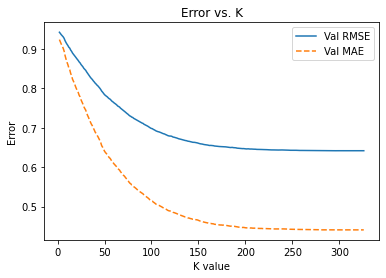

In [93]:
k_array = np.arange(2, 327)
val_rmse_list, val_mae_list = [], []

for k in k_array:
    
    filled, _ = compute_filled_matrix(train_pivot, k)
    val_rmse, val_mae = eval(val, filled)

    val_rmse_list.append(val_rmse)
    val_mae_list.append(val_mae)

plt.plot(k_array, val_rmse_list, label = 'Val RMSE')
plt.plot(k_array, val_mae_list, '--', label = 'Val MAE')
plt.legend(loc = 1)
plt.title('Error vs. K')
plt.ylabel('Error')
plt.xlabel('K value')

In [193]:
## all users 
filled_200, _ = compute_filled_matrix(train_pivot, 50)
val_rmse, val_mae = eval(val, filled_200)
print(np.mean(val_rmse))
print(np.mean(val_mae))

0.783816934009739
0.6404189186865243


We beat both baselines!! I want to explicitly include information from other users as well. Lets go back to our approach to average the most similar users

In [209]:
def evaluateCosRecommendation(filled_df, split_df, user= '5tXRxr4T24Awl7vjyCvIcQ', avg_user = 2): 
    
    ordered = find_sim_users(filled_df, user)
    top5 = ordered[:avg_user].index.to_list()
    sim_users = filled_df[split_df.columns]
    sim_users = sim_users.loc[sim_users.index.isin(top5)]
    avg_ratings = pd.DataFrame(sim_users.mean(axis=0)).T
    user_of_interest = split_df.loc[split_df.index==user]

    mask = user_of_interest.notna()
    preds = avg_ratings.values[mask]
    gt = user_of_interest.values[mask]

    rmse = mean_squared_error(gt, preds, squared=False)
    mae = mean_absolute_error(gt, preds)

    return rmse, mae

def evaluateRecommendation(filled_df, U_df, split_df, user= '5tXRxr4T24Awl7vjyCvIcQ', avg_user = 2): 
    
    ordered = find_sim_users(U_df, user)
    top5 = ordered[:avg_user].index.to_list()
    #print(top5)
    sim_users = filled_df[split_df.columns]
    sim_users = sim_users.loc[sim_users.index.isin(top5)]
    avg_ratings = pd.DataFrame(sim_users.mean(axis=0)).T
    user_of_interest = split_df.loc[split_df.index==user]

    mask = user_of_interest.notna()
    preds = avg_ratings.values[mask]
    gt = user_of_interest.values[mask]

    rmse = mean_squared_error(gt, preds, squared=False)
    mae = mean_absolute_error(gt, preds)

    return rmse, mae

def find_sim_users(filled_df, user):
    """
    Takes in the SVD array and the user of interest for whom we want
    to make recommendations 
    """
    # Normalize the reconstructed matrix 
    avg_ratings = filled_df.mean(axis=1)
    user_ratings_centered = filled_df.sub(avg_ratings, axis=0)
    similarities = cosine_similarity(user_ratings_centered)
    cosine_similarity_df = pd.DataFrame(similarities, index=user_ratings_centered.index, columns=user_ratings_centered.index)
    #cosine_similarity_df.head()

    # find the most similar users and return a sorted series 
    cosine_similarity_series = cosine_similarity_df.loc[user]
    ordered_similarities = cosine_similarity_series.sort_values(ascending=False)
    #print(ordered_similarities)

    return ordered_similarities

In [195]:
# for a single user 
filled_200, U = compute_filled_matrix(train_pivot, k_val=50)
U = pd.DataFrame(U, index=train_pivot.index)
val_rec_rmse, val_rec_mae = evaluateRecommendation(filled_200, U, val_pivot)
print(val_rec_rmse)
print(val_rec_mae)

0.5245323537500373
0.39544345176054296


In [196]:
rmse = []
mae = []
users_of_interest = val_pivot.index.values
for user_id in users_of_interest:
    user_rmse, user_mae = evaluateRecommendation(filled_200, U, val_pivot, user_id)
    rmse.append(user_rmse)
    mae.append(user_mae)

print('Average mean squared error: ', np.round(np.mean(rmse),5))
print('Average mean absolute error: ', np.round(np.mean(mae),5))

Average mean squared error:  0.85655
Average mean absolute error:  0.67309


Text(0.5, 0, 'K value')

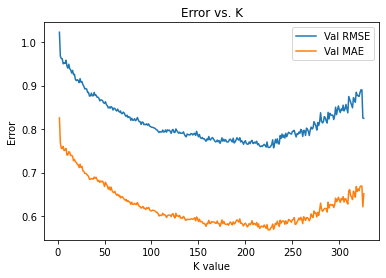

In [98]:
k_array = np.arange(2, 327)
val_rmse_list, val_mae_list = [], []

for k in k_array:
    
    filled, U = compute_filled_matrix(train_pivot, k)
    U = pd.DataFrame(U, index=train_pivot.index)
    rmse = []
    mae = []
    users_of_interest = val_pivot.index.values
    for user in users_of_interest:
        user_rmse, user_mae = evaluateRecommendation(filled, U, val_pivot, user)
        rmse.append(user_rmse)
        mae.append(user_mae)

    val_rmse_list.append(np.mean(rmse))
    val_mae_list.append(np.mean(mae))

#plt.plot(k_array, train_rmse_list, label = 'Train RMSE')
plt.plot(k_array, val_rmse_list, label = 'Val RMSE')
#plt.plot(k_array, train_mae_list, label = 'Train MAE')
plt.plot(k_array, val_mae_list, label = 'Val MAE')
plt.legend(loc = 1)
plt.title('Error vs. K')
plt.ylabel('Error')
plt.xlabel('K value')

In [99]:
print('Minimum RMSE on val: {}, index: {} '.format(min(val_rmse_list), val_rmse_list.index(min(val_rmse_list))))
print('Minimum MAE on val: {}, index: {} '.format(min(val_mae_list), val_mae_list.index(min(val_mae_list))))
print('K at minimum rmse index: ', k_array[val_rmse_list.index(min(val_rmse_list))])
print('K at minimum mae index: ', k_array[val_mae_list.index(min(val_mae_list))])

Minimum RMSE on val: 0.7569774462765068, index: 228 
Minimum MAE on val: 0.568329974606354, index: 224 
K at minimum rmse index:  230
K at minimum mae index:  226


Text(0.5, 0, 'K value')

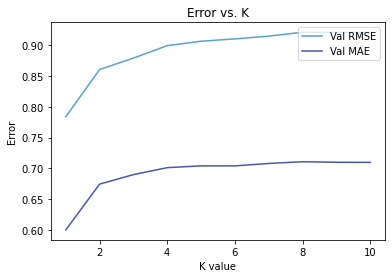

In [198]:
numb_users = np.arange(1, 11)
val_rmse_list, val_mae_list = [], []
filled, U = compute_filled_matrix(train_pivot, 50)
U = pd.DataFrame(U, index=train_pivot.index)

for i in numb_users:
    
    rmse = []
    mae = []
    users_of_interest = val_pivot.index.values
    for user in users_of_interest:
        user_rmse, user_mae = evaluateRecommendation(filled, U, val_pivot, user, avg_user= i)
        rmse.append(user_rmse)
        mae.append(user_mae)

    val_rmse_list.append(np.mean(rmse))
    val_mae_list.append(np.mean(mae))


plt.plot(numb_users, val_rmse_list, label = 'Val RMSE')
plt.plot(numb_users, val_mae_list, label = 'Val MAE')
plt.legend(loc = 1)
plt.title('Error vs. K')
plt.ylabel('Error')
plt.xlabel('K value')

In [102]:
print('Minimum RMSE on val: {}, index: {} '.format(min(val_rmse_list), val_rmse_list.index(min(val_rmse_list))))
print('Minimum MAE on val: {}, index: {} '.format(min(val_mae_list), val_mae_list.index(min(val_mae_list))))
print('K at minimum rmse index: ', numb_users[val_rmse_list.index(min(val_rmse_list))])
print('K at minimum mae index: ', numb_users[val_mae_list.index(min(val_mae_list))])

Minimum RMSE on val: 0.6435933813437641, index: 0 
Minimum MAE on val: 0.3683432815908142, index: 0 
K at minimum rmse index:  1
K at minimum mae index:  1


Using the SVD calculations gave us better results on the validation set than using similar users but let us evaluate both methonds on the test set

## Evaluating on Test

In [199]:
## using just SVD
filled_200, _ = compute_filled_matrix(train_pivot, 50)
test_rmse, test_mae = eval(test,filled_200)

print('Average mean squared error: ', np.round(test_rmse,5))
print('Average mean absolute error: ', np.round(test_mae,5))

Average mean squared error:  0.91781
Average mean absolute error:  0.93803


In [200]:
filled_277, U = compute_filled_matrix(train_pivot, 50)
U = pd.DataFrame(U, index=train_pivot.index)
test_pivot = makePivot(test)
rmse = []
mae = []
users_of_interest = test_pivot.index.values
for user_id in users_of_interest:
    user_rmse, user_mae = evaluateRecommendation(filled_277, U, test_pivot, user_id, avg_user=2)
    rmse.append(user_rmse)
    mae.append(user_mae)

print('Average mean squared error: ', np.round(np.mean(rmse),5))
print('Average mean absolute error: ', np.round(np.mean(mae),5))

Average mean squared error:  0.94189
Average mean absolute error:  0.76648


In [205]:
filled_277, U = compute_filled_matrix(train_pivot, 50)
U = pd.DataFrame(U, index=train_pivot.index)
test_pivot = makePivot(test)
rmse = []
mae = []
users_of_interest = test_pivot.index.values
for user_id in users_of_interest:
    user_rmse, user_mae = evaluateCosRecommendation(filled_277, test_pivot, user_id, avg_user=3)
    rmse.append(user_rmse)
    mae.append(user_mae)

print('Average mean squared error: ', np.round(np.mean(rmse),5))
print('Average mean absolute error: ', np.round(np.mean(mae),5))

Average mean squared error:  0.94085
Average mean absolute error:  0.76397


Making recommendations based on similar users works better on the test set but we are only able to beat one baseline. Lets try a different way of finding similar users and see if that can improve perforance.

## Incorporating Text Reviews

We have to first clean up the text data

In [55]:
import re  # For preprocessing
import spacy  # For preprocessing
import unidecode


In [101]:
filtered_nola.head()

,review_id,user_id,business_id,stars,text,name,city,biz_stars,biz_review_count,categories,average_stars
0,lDoxqlDKb4H7zpI_zJ01aA,Ye-9S8f2dt41UBfy4lXffA,W4ZEKkva9HpAdZG88juwyQ,2,The French bread is crusty an warm but... Ice ...,Mr. B's Bistro,New Orleans,4.0,2064,"Bars, Breakfast & Brunch, Restaurants, Barbequ...",3.98
1,uNnqb1qJxUDS4qrM_mZxtA,Ye-9S8f2dt41UBfy4lXffA,PzhPMkaNYiKDTHoTG0r8rw,5,Do I love this place? Pho sure! Phó Cam Ly is ...,Pho Cam Ly,New Orleans,4.5,178,"Vietnamese, Restaurants",3.98
2,cA-WwCC7OFF6CreyTC_l2w,Ye-9S8f2dt41UBfy4lXffA,GBTPC53ZrG1ZBY3DT8Mbcw,5,"We had the coffee, grillade & grits ($15) and ...",Luke,New Orleans,4.0,4554,"German, Restaurants, Seafood, Cocktail Bars, F...",3.98
3,lJpQrjnwqe9U3epf09FjcQ,Ye-9S8f2dt41UBfy4lXffA,GBTPC53ZrG1ZBY3DT8Mbcw,2,Lüke Restaurant is consistent with their food:...,Luke,New Orleans,4.0,4554,"German, Restaurants, Seafood, Cocktail Bars, F...",3.98
4,F1Q-Jh0r42iJ5OFy5QKMBA,Ye-9S8f2dt41UBfy4lXffA,OINbC0rpDVJ5bfxt3LO9fw,5,If you go during buffet time and get anything ...,Li'l Dizzy's Cafe,New Orleans,4.5,651,"Restaurants, Cajun/Creole",3.98


### Data Cleaning

In [111]:
for index,text in enumerate(filtered_nola['text'][-5:]):
  print('Review %d:\n'%(index+1),text)


Review 1:
 Saba is a family favorite. We've been here many times. The star of the show has always been the hummus and pita bread. I especially love the blue crab hummus. The entrees are great and we often order a few to share. Last time I went, we got a few of their nonalcoholic drinks and they were so refreshing in the sun. The service is always stellar. This time we went, my partner had a hurt leg and they were great and accommodating. 

They have covered outdoor seating.
Review 2:
 I always recommend French Truck to folks. It is a solid place with good coffee and food and a great atmosphere, what more could you want. Their outdoor seating is fantastic and the best on a beautiful day. The service is always great and fast. 

They are also very good about social distancing.
Review 3:
 I loved my experience here!! The service was great and fast. The tacos were sooo good and well priced (my friends even ordered seconds). The fun drinks we got (unfortunately I can't remember the names) we

In [103]:
## Expanding Contractions 
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))


def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

In [104]:
# expanding contractions 
filtered_nola['cleaned'] = filtered_nola['text'].apply(lambda x:expand_contractions(x))

In [106]:
## Making all words lowercase, removing punctuation, URLs, and white spaces 
filtered_nola['cleaned'] = filtered_nola['cleaned'].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', ' ', x))
filtered_nola['cleaned'] = filtered_nola['cleaned'].str.lower().apply(lambda x: re.sub(r"[\d\n\-\./]+", ' ', x))
filtered_nola['cleaned'] = filtered_nola['cleaned'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [125]:
filtered_nola['cleaned'] = filtered_nola['cleaned'].replace(' ', np.nan)
filtered_nola['cleaned'] = filtered_nola['cleaned'].apply(lambda x: unidecode.unidecode(x))
filtered_nola['cleaned'] = filtered_nola['cleaned'].apply(lambda x: re.sub(' +',' ',x))

In [121]:
filtered_nola.isna().sum()

review_id           0
user_id             0
business_id         0
stars               0
text                0
name                0
city                0
biz_stars           0
biz_review_count    0
categories          0
average_stars       0
cleaned             0
lemmatized          0
dtype: int64

In [127]:
for index,text in enumerate(filtered_nola['cleaned'][-5:]):
  print('Review %d:\n'%(index+1),text)


Review 1:
 saba is a family favorite weve been here many times the star of the show has always been the hummus and pita bread i especially love the blue crab hummus the entrees are great and we often order a few to share last time i went we got a few of their nonalcoholic drinks and they were so refreshing in the sun the service is always stellar this time we went my partner had a hurt leg and they were great and accommodating they have covered outdoor seating 
Review 2:
 i always recommend french truck to folks it is a solid place with good coffee and food and a great atmosphere what more could you want their outdoor seating is fantastic and the best on a beautiful day the service is always great and fast they are also very good about social distancing 
Review 3:
 i loved my experience here the service was great and fast the tacos were sooo good and well priced my friends even ordered seconds the fun drinks we got unfortunately i cannot remember the names were delicious on a warm day 

Data preprocessing

In [134]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
nlp.Defaults.stop_words |= {'food', 'service', 'drinks', 'restaurant', 'come', 'place', 'get', 'go', 'just', 'come'}

In [135]:
texts = filtered_nola['cleaned'].tolist()
lemmatized_texts = []
for doc in nlp.pipe(texts, batch_size=1000, n_process=4):
    lemmatized_texts.append(' '.join([token.lemma_ for token in doc if (token.is_stop==False)]))

In [136]:
filtered_nola['lemmatized'] = lemmatized_texts

In [137]:
filtered_nola.head()

,review_id,user_id,business_id,stars,text,name,city,biz_stars,biz_review_count,categories,average_stars,cleaned,lemmatized
0,lDoxqlDKb4H7zpI_zJ01aA,Ye-9S8f2dt41UBfy4lXffA,W4ZEKkva9HpAdZG88juwyQ,2,The French bread is crusty an warm but... Ice ...,Mr. B's Bistro,New Orleans,4.0,2064,"Bars, Breakfast & Brunch, Restaurants, Barbequ...",3.98,the french bread is crusty an warm but ice col...,french bread crusty warm ice cold butter serio...
1,uNnqb1qJxUDS4qrM_mZxtA,Ye-9S8f2dt41UBfy4lXffA,PzhPMkaNYiKDTHoTG0r8rw,5,Do I love this place? Pho sure! Phó Cam Ly is ...,Pho Cam Ly,New Orleans,4.5,178,"Vietnamese, Restaurants",3.98,do i love this place pho sure pho cam ly is a ...,love pho sure pho cam ly great vietnamese neig...
2,cA-WwCC7OFF6CreyTC_l2w,Ye-9S8f2dt41UBfy4lXffA,GBTPC53ZrG1ZBY3DT8Mbcw,5,"We had the coffee, grillade & grits ($15) and ...",Luke,New Orleans,4.0,4554,"German, Restaurants, Seafood, Cocktail Bars, F...",3.98,we had the coffee grillade grits and shrimp gr...,coffee grillade grit shrimp grit plus add crab...
3,lJpQrjnwqe9U3epf09FjcQ,Ye-9S8f2dt41UBfy4lXffA,GBTPC53ZrG1ZBY3DT8Mbcw,2,Lüke Restaurant is consistent with their food:...,Luke,New Orleans,4.0,4554,"German, Restaurants, Seafood, Cocktail Bars, F...",3.98,luke restaurant is consistent with their food ...,luke consistent fresh prepare request correct ...
4,F1Q-Jh0r42iJ5OFy5QKMBA,Ye-9S8f2dt41UBfy4lXffA,OINbC0rpDVJ5bfxt3LO9fw,5,If you go during buffet time and get anything ...,Li'l Dizzy's Cafe,New Orleans,4.5,651,"Restaurants, Cajun/Creole",3.98,if you go during buffet time and get anything ...,buffet time buffet miss good opportunity true ...


In [147]:
#filtered_nola.to_csv('./cleaned_revs.csv')

In [56]:
lemma_reviews = pd.read_csv('cleaned_revs.csv')

In [57]:
train_reviews = lemma_reviews.loc[lemma_reviews['review_id'].isin(train['review_id'])]

### Text PreProcessing 

In [58]:
# Aggregates all of the reviews for a single user
df_grouped=lemma_reviews[['user_id','lemmatized']].astype(str).groupby(by='user_id')['lemmatized'].apply(' '.join).reset_index()
df_grouped.head()

,user_id,lemmatized
0,-MRD72DXnVgjkM1AVFp7Nw,seriously negative pho cam ly highly addictive...
1,-SO_K8oLVH_9J23z2MtjGg,short good tacos delicious top blend delicious...
2,-Tg5YTEMbnYw3fQN99xKCQ,breakfast ok need work grit need lot salt butt...
3,-V7frksbFjKQYVhrPnnlPw,come work lunch softshell crab blt come toast ...
4,-_Y8Mal7S750TsB6yMMDHA,get burger abd awesome fry delicious pretty qu...


In [59]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result


tokenized_list = df_grouped['lemmatized'].apply(lambda x: preprocess(x))
df_grouped['tokenized'] = tokenized_list
dictionary = gensim.corpora.Dictionary(df_grouped['tokenized'])
dictionary.filter_extremes(no_below=15, no_above=0.25, keep_n=100000)

In [113]:
df_grouped.head()

,user_id,lemmatized,tokenized
0,-MRD72DXnVgjkM1AVFp7Nw,seriously negative pho cam ly highly addictive...,"[seriously, negative, highly, addictive, thai,..."
1,-SO_K8oLVH_9J23z2MtjGg,short good tacos delicious top blend delicious...,"[short, good, tacos, delicious, blend, delicio..."
2,-Tg5YTEMbnYw3fQN99xKCQ,breakfast ok need work grit need lot salt butt...,"[breakfast, need, work, grit, need, salt, butt..."
3,-V7frksbFjKQYVhrPnnlPw,come work lunch softshell crab blt come toast ...,"[come, work, lunch, softshell, crab, come, toa..."
4,-_Y8Mal7S750TsB6yMMDHA,get burger abd awesome fry delicious pretty qu...,"[burger, awesome, delicious, pretty, quick, oy..."


In [61]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 access
1 accurate
2 action
3 addictive
4 adorn
5 ample
6 anchovy
7 angelo
8 appetite
9 appetize
10 apricot


In [114]:
bow_corpus = [dictionary.doc2bow(doc) for doc in df_grouped['tokenized'].values]

bow_doc_4310 = bow_corpus[10]

for i in range(10):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], bow_doc_4310[i][1]))

Word 27 ("boyfriend") appears 1 time.
Word 29 ("brief") appears 1 time.
Word 31 ("budget") appears 1 time.
Word 53 ("confusing") appears 1 time.
Word 62 ("dash") appears 1 time.
Word 78 ("effort") appears 2 time.
Word 101 ("gift") appears 1 time.
Word 123 ("jean") appears 1 time.
Word 128 ("kill") appears 1 time.
Word 138 ("legit") appears 2 time.


In [65]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

### LDA

In [116]:
lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=38, id2word=dictionary, passes=10, workers=4)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.006*"mondo" + 0.003*"complementary" + 0.003*"paprika" + 0.002*"alongside" + 0.002*"simon" + 0.002*"blossom" + 0.002*"treme" + 0.002*"popcorn" + 0.002*"dong" + 0.001*"tinga"
Topic: 1 
Words: 0.004*"greatness" + 0.001*"historical" + 0.001*"cotija" + 0.001*"francisco" + 0.001*"faced" + 0.001*"chick" + 0.001*"soooooo" + 0.001*"ultimate" + 0.001*"mais" + 0.001*"vintage"
Topic: 2 
Words: 0.011*"nole" + 0.009*"trenasse" + 0.004*"allergic" + 0.003*"copeland" + 0.002*"tokyo" + 0.002*"tsunami" + 0.002*"socialize" + 0.001*"explore" + 0.001*"boba" + 0.001*"lush"
Topic: 3 
Words: 0.001*"hana" + 0.000*"walnut" + 0.000*"girlfriend" + 0.000*"martin" + 0.000*"bark" + 0.000*"roommate" + 0.000*"charred" + 0.000*"nole" + 0.000*"kabob" + 0.000*"toup"
Topic: 4 
Words: 0.003*"casa" + 0.002*"security" + 0.001*"piss" + 0.000*"epic" + 0.000*"solo" + 0.000*"speciality" + 0.000*"bulldog" + 0.000*"channel" + 0.000*"zone" + 0.000*"barrel"
Topic: 5 
Words: 0.004*"campus" + 0.001*"delightfully" + 0

In [175]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=df_grouped['tokenized'].values, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3273501987999022


In [181]:
def compute_coherence_values(corpus, dictionary, k, a=None, b=None):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10)
                                        #    alpha=a,
                                        #    eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df_grouped['tokenized'].values, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

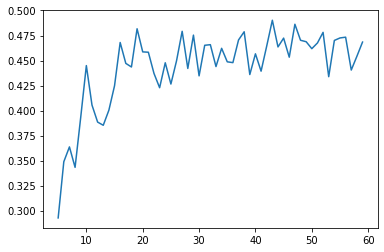

In [186]:
# Topics range
min_topics = 5
max_topics = 60
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
model_results = []

for k in topics_range:
    # get the coherence score for the given parameters
    cv = compute_coherence_values(corpus=corpus_tfidf, dictionary=dictionary, k=k)
    # Save the model results
    model_results.append(cv)


plt.plot(topics_range, model_results)

In [189]:
print(max(model_results))
print(model_results.index(max(model_results)))

0.49025110933736676
38


In [202]:
lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=38, id2word=dictionary, passes=100, workers=4)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.013*"mondo" + 0.003*"complementary" + 0.003*"paprika" + 0.002*"lech" + 0.002*"belong" + 0.000*"doberge" + 0.000*"nugget" + 0.000*"approach" + 0.000*"conveniently" + 0.000*"margs"
Topic: 1 
Words: 0.009*"decadent" + 0.008*"tail" + 0.008*"daiquiri" + 0.008*"shred" + 0.008*"marinara" + 0.008*"mushy" + 0.008*"serving" + 0.008*"margherita" + 0.008*"lech" + 0.008*"kill"
Topic: 2 
Words: 0.015*"roommate" + 0.014*"doberge" + 0.013*"focus" + 0.012*"conveniently" + 0.012*"garnish" + 0.012*"meril" + 0.011*"exciting" + 0.011*"array" + 0.010*"wagyu" + 0.010*"couch"
Topic: 3 
Words: 0.000*"sanitizer" + 0.000*"pisco" + 0.000*"margs" + 0.000*"marshmallow" + 0.000*"rouge" + 0.000*"mahoney" + 0.000*"camellia" + 0.000*"martinis" + 0.000*"solely" + 0.000*"allergic"
Topic: 4 
Words: 0.005*"boyfriend" + 0.003*"coolinary" + 0.003*"covid" + 0.002*"fiance" + 0.002*"partner" + 0.002*"terrific" + 0.002*"banh" + 0.002*"companion" + 0.002*"ribeye" + 0.002*"gnocchi"
Topic: 5 
Words: 0.000*"sardou

### Trying Other Methods to Incorporate Text

In [117]:
df_grouped.head(3)

,user_id,lemmatized,tokenized
0,-MRD72DXnVgjkM1AVFp7Nw,seriously negative pho cam ly highly addictive...,"[seriously, negative, highly, addictive, thai,..."
1,-SO_K8oLVH_9J23z2MtjGg,short good tacos delicious top blend delicious...,"[short, good, tacos, delicious, blend, delicio..."
2,-Tg5YTEMbnYw3fQN99xKCQ,breakfast ok need work grit need lot salt butt...,"[breakfast, need, work, grit, need, salt, butt..."


In [118]:
data = df_grouped['tokenized'].values
tagged_data = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(data)]

In [119]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=2,
                dm =1, 
                dm_mean = 1,
                workers = 4)
  
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [120]:
model.dv.most_similar('278', topn=10)

[('306', 0.8196471333503723),
 ('208', 0.8081722855567932),
 ('214', 0.7911342978477478),
 ('299', 0.7860674262046814),
 ('277', 0.7841057777404785),
 ('188', 0.7798364758491516),
 ('168', 0.7755629420280457),
 ('0', 0.7734951972961426),
 ('71', 0.7611597180366516),
 ('261', 0.759547770023346)]

In [121]:
df_grouped['lemmatized'].iloc[0]

'seriously negative pho cam ly highly addictive thai tea delectable spring roll tofu avocado perfect oversized steamed bun slider soothe chicken pho completely love menu selection outside seat free street parking directly price beat opinion actually eat lunch today get mixed emotion district donut slider brew good sure worth price donut ok try chocolate glaze meh cinnamon sugar good cheeseburger slider fry chicken slider blt slider good favorite far blt say low price district solid star rent high justify price charge slider donut goodness sake say money burn hole wallet em try atmosphere great staff notch go surrey cafe juice bar sunday brunch seat quickly expect m ideally want order different dining partner trade half double fun fab try spinach cheese melt focaccia avocado pesto sandwich chicken superb try curious menu item health conscious folk vegan option lovely juice ingredient choose unfortunately ginger sample juice day restock say quality piece art wall sale light ship gift tow

In [122]:
df_grouped['lemmatized'].iloc[278]

'come app wine not blow away decent favorite gorgonzola cheesecake second onion cheese tart crawfish crepe atmosphere new orlean nice bit creepy history supposedly haunt owner building seance lounge nd floor ghost say appear apparently pop early afternoon ask nicely set table day ghost wine bread fun visit app price bit dinner slider good good limoncello poppy seed donut cold brew iced coffee fun atmosphere friendly staff oh yeah brulee top cinnamon roll totally change way look cinnamon roll delicious pozole day tender pork plentiful mound hominy spicy broth serve add avocado lime dry spice herb jalapeno onion cabbage remind home proof solid minute silence friend slurp spicy goodness chilly day green sauce spicy chip hot salsa plentiful greet smile staff prompt courteous tamal get moist chicken flavorful masa bit mushy taste feed people substantial meal plus tip definitely menudo weekend update currently have pretty severe gastrointestinal upset definitely come love chip salsa great sa

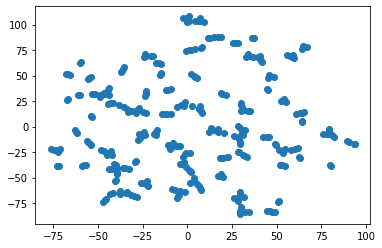

In [130]:
# doc_tags is just a list of every unique document tag/beer_id
doc_tags = list(model.dv.index_to_key)# get the vector for each doc_tag
X = model[doc_tags]# Fit and transform a t-SNE object with the vector data for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=2, n_iter = 2000, metric='cosine', random_state=42)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=doc_tags, columns=['x', 'y'])# create a scatterplot of the resulting 2-dimensional data
plt.scatter(df['x'], df['y'])

## Lets try using the similar users we found here back in our RecSys

In [124]:
sim_users_dict = {}
for row in df_grouped.itertuples(): 
    sim_users_dict[row.user_id] = model.dv.most_similar(str(row.Index), topn=50)

In [128]:
def evaluateRecommendation(filled_df, split_df, user= '5tXRxr4T24Awl7vjyCvIcQ', avg_user = 2): 
    
    ordered = sim_users_dict[user]
    top5 = ordered[:avg_user]
    user_idx = []
    user_id_list = []
    for itm in top5:
        user_idx.append(itm[0])
    for idx in user_idx:
        user_id_list.append(df_grouped['user_id'].iloc[int(idx)])
    sim_users = filled_df[split_df.columns]
    sim_users = sim_users.loc[sim_users.index.isin(user_id_list)]
    #print(sim_users)
    avg_ratings = pd.DataFrame(sim_users.mean(axis=0)).T
    user_of_interest = split_df.loc[split_df.index==user]

    mask = user_of_interest.notna()
    preds = avg_ratings.values[mask]
    gt = user_of_interest.values[mask]

    rmse = mean_squared_error(gt, preds, squared=False)
    mae = mean_absolute_error(gt, preds)

    return rmse, mae

In [129]:
val_pivot = makePivot(val)
filled, _ = compute_filled_matrix(train_pivot, 230)
rmse = []
mae = []
users_of_interest = val_pivot.index.values
for user_id in users_of_interest:
    user_rmse, user_mae = evaluateRecommendation(filled, val_pivot, user_id, avg_user = 1)
    rmse.append(user_rmse)
    mae.append(user_mae)

print('Average mean squared error: ', np.round(np.mean(rmse),5))
print('Average mean absolute error: ', np.round(np.mean(mae),5))

Average mean squared error:  1.08896
Average mean absolute error:  0.86274


In [324]:
k_array = np.arange(2, 327)
numb_users = np.arange(1,11)
k_rmse_list, k_mae_list = [], []

for k in k_array:
    val_rmse_list, val_mae_list = [], []
    for numb in numb_users: 
        filled = compute_filled_matrix(train_pivot, k)
        rmse = []
        mae = []
        users_of_interest = val_pivot.index.values
        for user in users_of_interest:
            user_rmse, user_mae = evaluateRecommendation(filled, val_pivot, user, avg_user = numb)
            rmse.append(user_rmse)
            mae.append(user_mae)

        val_rmse_list.append(np.mean(rmse))
        val_mae_list.append(np.mean(mae))

    k_rmse_list.append(val_rmse_list)
    k_mae_list.append(val_mae_list)


In [ ]:
#plt.plot(k_array, train_rmse_list, label = 'Train RMSE')
plt.plot(k_array, val_rmse_list, '--', label = 'Val RMSE')
#plt.plot(k_array, train_mae_list, label = 'Train MAE')
plt.plot(k_array, val_mae_list, '--', label = 'Val MAE')
plt.legend(loc = 1)
plt.title('Error vs. K')
plt.ylabel('Error')
plt.xlabel('K value')

In [138]:
len(df_grouped['tokenized'].to_list())

327

## Another attempt this time using truncated SVD

In [142]:
tfidf_vec = TfidfVectorizer(analyzer='word', min_df = 2)

def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)    
train_tfidf = tfidf.fit_transform(df_grouped['tokenized'].to_list())

Number of components = 3 and explained variance = 0.06767264468166372
Number of components = 5 and explained variance = 0.10702566903616587
Number of components = 10 and explained variance = 0.16040537340140215
Number of components = 15 and explained variance = 0.1984595752970498
Number of components = 20 and explained variance = 0.23163205585563157
Number of components = 30 and explained variance = 0.28648700186033227
Number of components = 40 and explained variance = 0.33413576305313447
Number of components = 50 and explained variance = 0.37690307991296546
Number of components = 100 and explained variance = 0.5551089808192369
Number of components = 150 and explained variance = 0.6945043802041461
Number of components = 200 and explained variance = 0.8082026692472151
Number of components = 250 and explained variance = 0.8999079000041241
Number of components = 300 and explained variance = 0.971329696729735


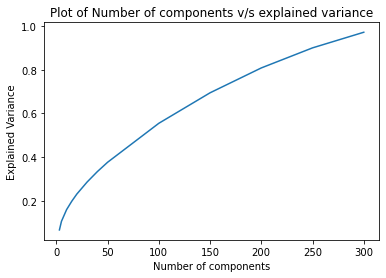

In [143]:
# Program to find the optimal number of components for Truncated SVD
n_comp = [3, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300] # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    svd.fit(train_tfidf)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
    

plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [146]:
svd = TruncatedSVD(n_components=300)
tfidf_svd = svd.fit_transform(train_tfidf)

In [151]:
tfidf_svd = pd.DataFrame(tfidf_svd, index = train_pivot.index)
tfidf_svd.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
user_id,,,,,,,,,,,,,,,,,,,,,
-MRD72DXnVgjkM1AVFp7Nw,0.646475,-0.005477,-0.066595,0.030945,-0.009354,-0.010320,-0.055666,0.051735,0.079645,-0.113431,...,0.020315,0.020058,-0.004838,-0.005427,-0.001493,-0.016998,-0.014617,-0.013640,-0.001689,0.000185
-SO_K8oLVH_9J23z2MtjGg,0.498146,-0.119526,-0.091155,0.177742,-0.003468,-0.143394,0.025415,-0.030927,-0.005275,-0.005603,...,-0.006215,0.027092,0.010172,0.012593,0.015313,0.021147,-0.002136,-0.003089,-0.004942,0.027422
-Tg5YTEMbnYw3fQN99xKCQ,0.500308,0.146390,-0.032099,-0.022158,0.090939,0.021051,-0.030686,-0.081484,0.070989,0.020807,...,0.003156,0.019519,0.000170,0.006745,-0.002778,-0.000304,0.006996,0.005280,-0.014930,0.006049
-V7frksbFjKQYVhrPnnlPw,0.766176,0.063415,0.159567,-0.263082,0.012028,0.012063,-0.014858,0.041805,0.022864,-0.050263,...,-0.051366,-0.008564,0.001628,-0.062460,-0.023196,0.098947,-0.055493,0.019284,0.026093,0.005919
-_Y8Mal7S750TsB6yMMDHA,0.589050,0.037032,0.114333,-0.024557,-0.007197,-0.111009,0.089991,-0.026967,0.158262,-0.016101,...,-0.016647,-0.024486,0.001289,-0.010082,-0.005354,0.000849,0.012468,-0.010637,-0.000428,-0.017411


In [159]:
filled_277, U = compute_filled_matrix(train_pivot, 230)
rmse = []
mae = []
users_of_interest = val_pivot.index.values
for user_id in users_of_interest:
    user_rmse, user_mae = evaluateRecommendation(filled_277, tfidf_svd, val_pivot, user_id, avg_user=2)
    rmse.append(user_rmse)
    mae.append(user_mae)

print('Average mean squared error: ', np.round(np.mean(rmse),5))
print('Average mean absolute error: ', np.round(np.mean(mae),5))

Average mean squared error:  0.77768
Average mean absolute error:  0.58713


Text(0.5, 0, 'K value')

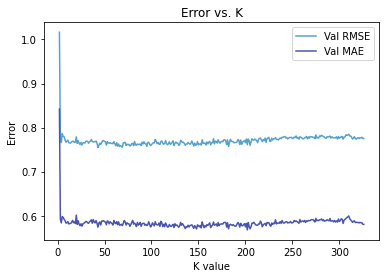

In [161]:
n_comp = np.arange(2, 327)
val_rmse_list, val_mae_list = [], []

filled, _ = compute_filled_matrix(train_pivot, 230)
users_of_interest = val_pivot.index.values

for n in n_comp:
    
    svd = TruncatedSVD(n_components=n)
    tfidf_svd = svd.fit_transform(train_tfidf)
    tfidf_svd = pd.DataFrame(tfidf_svd, index = train_pivot.index)

    rmse = []
    mae = []
  
    for user in users_of_interest:
        user_rmse, user_mae = evaluateRecommendation(filled, tfidf_svd, val_pivot, user)
        rmse.append(user_rmse)
        mae.append(user_mae)

    val_rmse_list.append(np.mean(rmse))
    val_mae_list.append(np.mean(mae))

#plt.plot(k_array, train_rmse_list, label = 'Train RMSE')
plt.plot(k_array, val_rmse_list, label = 'Val RMSE')
#plt.plot(k_array, train_mae_list, label = 'Train MAE')
plt.plot(k_array, val_mae_list, label = 'Val MAE')
plt.legend(loc = 1)
plt.title('Error vs. K')
plt.ylabel('Error')
plt.xlabel('K value')

In [163]:
print('Minimum RMSE on val: {}, index: {} '.format(min(val_rmse_list), val_rmse_list.index(min(val_rmse_list))))
print('Minimum MAE on val: {}, index: {} '.format(min(val_mae_list), val_mae_list.index(min(val_mae_list))))
print('K at minimum rmse index: ', n_comp[val_rmse_list.index(min(val_rmse_list))])
print('K at minimum mae index: ', n_comp[val_mae_list.index(min(val_mae_list))])

Minimum RMSE on val: 0.7545549923847422, index: 41 
Minimum MAE on val: 0.5677283708080847, index: 200 
K at minimum rmse index:  43
K at minimum mae index:  202


In [224]:
filled_277, _ = compute_filled_matrix(train_pivot, 41)
svd = TruncatedSVD(n_components=41)
tfidf_svd = svd.fit_transform(train_tfidf)
tfidf_svd = pd.DataFrame(tfidf_svd, index = train_pivot.index)

rmse = []
mae = []
users_of_interest = test_pivot.index.values
for user_id in users_of_interest:
    user_rmse, user_mae = evaluateRecommendation(filled_277, tfidf_svd, test_pivot, user_id, avg_user=2)
    rmse.append(user_rmse)
    mae.append(user_mae)

print('Average mean squared error: ', np.round(np.mean(rmse),5))
print('Average mean absolute error: ', np.round(np.mean(mae),5))

Average mean squared error:  0.92635
Average mean absolute error:  0.75671
